In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [2]:
pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 29.1 MB/s 
     |████████████████████████████████| 287 kB 32.5 MB/s 


In [3]:
import pandas as pd
import numpy as np
import re
import collections
import contractions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout,Bidirectional
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
import sqlite3
import csv
import sys
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk

In [5]:
quantize = '--quantize' in sys.argv

In [6]:
with open('/content/drive/MyDrive/Ass 7/stanfordSentimentTreebank/datasetSentences.txt') as infile:
    infile.readline()
    sentences = dict(line.strip().split('\t') for line in infile if len(line) > 0)

with open('/content/drive/MyDrive/Ass 7/stanfordSentimentTreebank/dictionary.txt') as infile:
    infile.readline()
    dictionary = dict(line.strip().split('|')[::-1] for line in infile if len(line) > 0)

with open('/content/drive/MyDrive/Ass 7/stanfordSentimentTreebank/sentiment_labels.txt') as infile:
    infile.readline()
    sentiments = dict(line.strip().strip('!').split('|') for line in infile if len(line) > 0)
    if quantize:
        sentiments = {k: int(float(v) * 5) for k, v in sentiments.items()}

with open('/content/drive/MyDrive/Ass 7/stanfordSentimentTreebank/datasetSplit.txt') as infile:
    infile.readline()
    splits = dict(line.strip().split(',') for line in infile if len(line) > 0)

In [7]:
conn = sqlite3.connect(':memory:')
conn.execute('CREATE TABLE sentences (id LONG PRIMARY KEY, sentence TEXT)')
conn.execute('CREATE TABLE dictionary (id LONG PRIMARY KEY, phrase TEXT)')
conn.execute('CREATE TABLE sentiments (phrase_id LONG PRIMARY KEY, sentiment {})'.format('INT' if quantize else 'FLOAT'))
conn.execute('CREATE TABLE splits (sentence_id LONG PRIMARY KEY, partition INT)')

conn.execute('CREATE INDEX sentences_sentence_idx ON sentences (sentence);')
conn.execute('CREATE INDEX dictionary_phrase_idx ON dictionary (phrase);')

conn.executemany('INSERT INTO sentences VALUES (?, ?)', sentences.items())
conn.executemany('INSERT INTO dictionary VALUES (?, ?)', dictionary.items())
conn.executemany('INSERT INTO sentiments VALUES (?, ?)', sentiments.items())
conn.executemany('INSERT INTO splits VALUES (?, ?)', splits.items())

conn.commit()
crs = conn.cursor()

crs.execute('''
        SELECT
            partition,
            sentence,
            sentiment
        FROM sentences 
            JOIN dictionary ON sentence = phrase
            JOIN sentiments ON dictionary.id = phrase_id
            JOIN splits ON sentences.id = sentence_id
        ''')


dataset = crs.fetchall()

In [8]:
for fname, partition in [['train', 1], ['test', 2], ['dev', 3]]:
    with open(fname + '.csv', 'w') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['sentence', 'sentiment'])
        for row in dataset:
            if row[0] == partition:
                writer.writerow(row[1:])

In [4]:
train = pd.read_csv("/content/drive/MyDrive/Ass 7/SST_2/train.csv", encoding='latin-1')

dev = pd.read_csv("/content/drive/MyDrive/Ass 7/SST_2/dev.csv", encoding='latin-1')
print(train)
print(dev)

                                         sentence_train Sentiment_train
0                 ... a bland murder-on-campus yawner .   very_negative
1     ... the picture 's cleverness is ironically mu...         neutral
2         classic cinema served up with heart and humor   very_positive
3                 entertaining enough , but nothing new        negative
4           insightfully written , delicately performed   very_positive
...                                                 ...             ...
8112  the phone rings and a voice tells you you 've ...         neutral
8113  to be more engaging on an emotional level , fu...         neutral
8114                       under-rehearsed and lifeless   very_negative
8115  wo n't be placed in the pantheon of the best o...   very_positive
8116  works , it 's thanks to Huston 's revelatory p...        positive

[8117 rows x 2 columns]
                                           sentence_dev  sentiment_dev
0     ... a hollow joke told by a cinema

In [5]:
train.shape


(8117, 2)

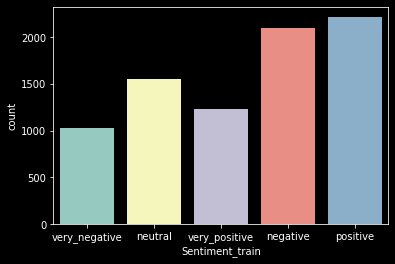

In [6]:
import seaborn as sns
sns.countplot(train["Sentiment_train"])

In [7]:
train["Sentiment_train"].value_counts()

positive         2216
negative         2092
neutral          1549
very_positive    1230
very_negative    1030
Name: Sentiment_train, dtype: int64

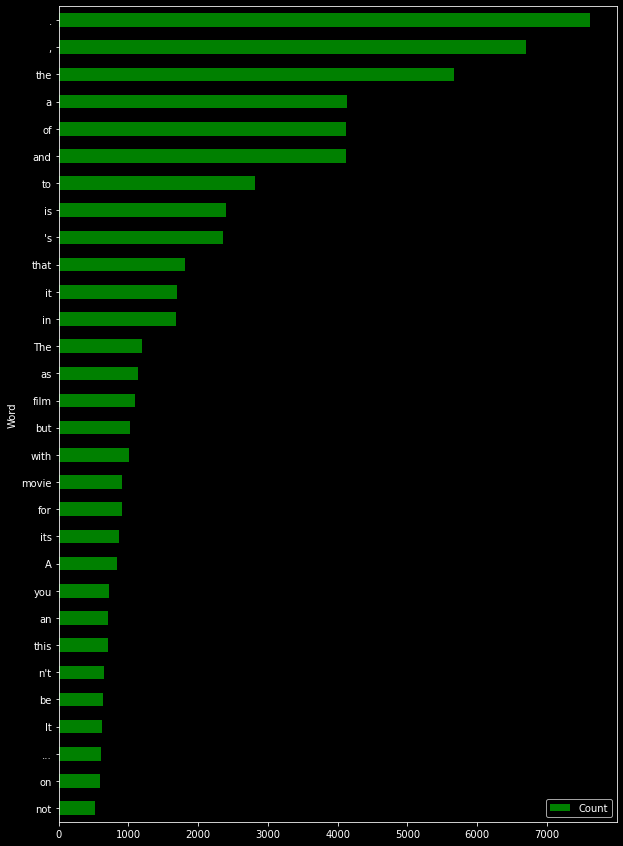

In [8]:
def word_count_plot(data):
     
     word_counter = collections.Counter([word for sentence in data for word in sentence.split()])
     most_count = word_counter.most_common(30)
     
     most_count = pd.DataFrame(most_count, columns=["Word", "Count"]).sort_values(by="Count")
     most_count.plot.barh(x = "Word", y = "Count", color="green", figsize=(10, 15))
word_count_plot(train["sentence_train"])

In [9]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [10]:
lem = WordNetLemmatizer()
def preprocessing(data):
      sms = contractions.fix(data) 
      sms = sms.lower()
      sms = re.sub(r'https?://S+|www.S+', "", sms).strip() 
      sms = re.sub("[^a-z ]", "", sms) 
      sms = sms.split() 
      sms = [lem.lemmatize(word) for word in sms if not word in set(stopwords.words("english"))]
      sms = " ".join(sms)
      return sms
X_train = train["sentence_train"].apply(preprocessing)
print(X_train )
X_dev = dev["sentence_dev"].apply(preprocessing)

0                             bland murderoncampus yawner
1       picture cleverness ironically muted people int...
2                       classic cinema served heart humor
3                         entertaining enough nothing new
4               insightfully written delicately performed
                              ...                        
8112        phone ring voice tell got seven day left live
8113    engaging emotional level funnier whole le deta...
8114                              underrehearsed lifeless
8115    wo nt placed pantheon best swashbuckler whole ...
8116            work thanks huston revelatory performance
Name: sentence_train, Length: 8117, dtype: object


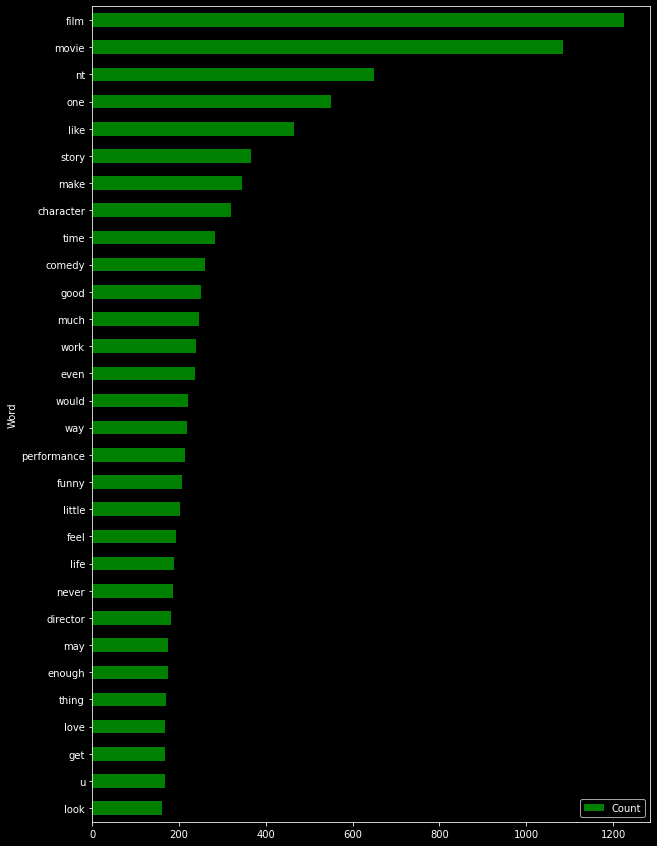

In [11]:
word_count_plot(X_train)

In [12]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [70]:
from sklearn.preprocessing import LabelEncoder
lb_enc = LabelEncoder()
y_train = lb_enc.fit_transform(train["Sentiment_train"])
y_dev = lb_enc.fit_transform(dev["sentiment_dev"])


In [81]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)
text_to_sequence_X_train = tokenizer.texts_to_sequences(X_train)
print(text_to_sequence_X_train)

[[394, 7160, 7161], [60, 2444, 2445, 2446, 53, 914, 7, 1417], [295, 144, 1062, 95, 78], [90, 25, 48, 34], [3729, 435, 1830, 2101], [81, 376, 55, 251], [15, 110, 598, 15, 25, 7162, 840, 1270, 95, 4888], [915, 7163, 2447], [1831, 19, 142, 1418, 3730, 222, 17, 4889, 74, 7164], [719, 534, 2448, 426, 264], [454, 198, 1419, 2972, 239], [454, 436, 252, 7165, 7166, 4890, 44], [33, 114, 3731, 189, 12, 985, 3732, 2449, 599, 276, 4891, 1271], [633, 1155, 74, 8, 21, 2973, 310, 720, 87, 35, 783, 2102, 7167, 7168], [211, 561, 138, 986, 179, 2, 1832], [25, 1063, 21, 1420, 1272, 4892, 111, 10, 76, 57, 144, 103], [18, 222], [3733, 2974, 211, 139, 10], [1833, 408, 85, 12, 3734, 80, 2450, 45, 437, 634, 246, 841, 2103, 7169, 600], [1611, 111, 10, 721, 27, 635, 173], [1612, 455, 6, 24, 61, 70, 247, 1, 361, 4893, 7170, 329], [1612, 34, 1], [7171, 282, 1613, 8, 240, 111, 10, 7172, 82], [1156, 88, 4, 58, 253, 916, 987, 2451, 601, 54, 362, 89, 4894], [455, 88, 34, 4895, 216, 4896, 4897, 480, 2975, 362, 192, 12

In [80]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_dev)
text_to_sequence_X_dev = tokenizer.texts_to_sequences(X_dev)
print(text_to_sequence_X_dev)

[[356, 221, 357, 88, 1471, 12, 17, 1472, 1473, 89, 222, 505], [1474, 506, 95, 1475, 807, 1476, 358, 223, 1477, 88, 273, 66, 274, 808, 507, 508, 359], [10, 3, 128, 30, 96, 10, 53, 97, 1478, 67], [360, 809, 1479, 112, 509, 3, 1480, 510, 98, 1481, 1482], [28, 810, 361, 1483, 10, 38, 362, 181, 1484, 1485, 811], [511, 812, 1486, 363, 1487, 13, 813], [30, 364, 814, 1488, 182, 365, 366, 815, 512], [816, 1489, 817, 367, 818, 1490, 368, 513, 514, 515], [1491, 68, 78, 1492, 516, 1493, 8, 1494, 819, 517, 1495, 1496, 1497, 155, 1498, 1499, 1500], [69, 820, 1, 1501, 62, 1502, 23, 98, 1503, 129, 518, 183, 1504, 519, 1505], [275, 1506, 1], [1507, 816, 821, 1508], [276, 822, 1, 113, 823, 824, 70, 1509, 1510, 1, 34, 825, 156], [520, 31, 369, 370, 2], [1, 98, 157, 521, 522, 371, 184, 1511], [277, 1512, 372, 373, 523, 224, 130, 18, 23], [1513, 826, 524, 525, 526, 827, 526, 828], [2, 829, 15, 374, 185, 830, 278, 1514, 831, 527], [1515, 375, 832, 833, 181, 1516, 131, 528, 834], [376, 835, 836, 837, 1517], 

In [82]:
max_length_sequence_X_train = max([len(i) for i in text_to_sequence_X_train])
 
padded_sequence_X_train = pad_sequences(text_to_sequence_X_train, maxlen=max_length_sequence_X_train, 
                                    padding = "pre") 
padded_sequence_X_train
print(max_length_sequence_X_train)

28


In [83]:
#max_length_sequence_X_dev = max([len(i) for i in text_to_sequence_X_train])
 
padded_sequence_X_dev = pad_sequences(text_to_sequence_X_dev, maxlen=28, 
                                    padding = "pre") 
padded_sequence_X_dev
#print(max_length_sequence_X_dev)

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  356,  221,  357,   88, 1471,   12,
          17, 1472, 1473,   89,  222,  505],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        1474,  506,   95, 1475,  807, 1476,  358,  223, 1477,   88,  273,
          66,  274,  808,  507,  508,  359],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   10,    3,  128,   30,
          96,   10,   53,   97, 1478,   67],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  360,  809, 1479,  112,  509,
           3, 1480,  510,   98, 1481, 1482],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   28,  810,  361, 1483,   10,
          38,  362,  181, 1484, 1485,  811],
       [   0,    0,    0,    0,    

In [84]:
VOC_SIZE = len(tokenizer.word_index)+1
print(VOC_SIZE)

14183


In [88]:
def create_model():
    
      model = Sequential()
      model.add(Embedding(VOC_SIZE,64, input_length=28))
      model.add(Dropout(0.5))
      model.add(Bidirectional(LSTM(64,return_sequences=True,activation="tanh",recurrent_dropout=0.5,recurrent_activation="sigmoid")))
      model.add(Dropout(0.5))
      model.add(LSTM(64))
      model.add(Dense(64, activation="relu"))
      model.add(Dropout(0.5))
      model.add(Dense(1, activation = "sigmoid"))
      return model
lstm_model = create_model()
lstm_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
lstm_model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 28, 64)            907712    
                                                                 
 dropout_34 (Dropout)        (None, 28, 64)            0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 28, 128)          66048     
 onal)                                                           
                                                                 
 dropout_35 (Dropout)        (None, 28, 128)           0         
                                                                 
 lstm_24 (LSTM)              (None, 64)                49408     
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                     

In [89]:
history=lstm_model.fit(padded_sequence_X_train, y_train, epochs = 250, batch_size=16, validation_data=(padded_sequence_X_dev, y_dev))

Epoch 1/250
508/508 [==============================] - 81s 109ms/step - loss: -150.7286 - accuracy: 0.1907 - val_loss: -415.0272 - val_accuracy: 0.2098
Epoch 2/250
508/508 [==============================] - 55s 107ms/step - loss: -981.8924 - accuracy: 0.1908 - val_loss: -1561.3314 - val_accuracy: 0.2098
Epoch 3/250
508/508 [==============================] - 54s 107ms/step - loss: -2522.6660 - accuracy: 0.1908 - val_loss: -3340.0601 - val_accuracy: 0.2098
Epoch 4/250
508/508 [==============================] - 53s 103ms/step - loss: -4727.3398 - accuracy: 0.1908 - val_loss: -5663.8481 - val_accuracy: 0.2098
Epoch 5/250
508/508 [==============================] - 55s 108ms/step - loss: -7386.3477 - accuracy: 0.1908 - val_loss: -8471.7695 - val_accuracy: 0.2098
Epoch 6/250
508/508 [==============================] - 52s 103ms/step - loss: -10998.6123 - accuracy: 0.2030 - val_loss: -7689.7773 - val_accuracy: 0.2098
Epoch 7/250
508/508 [==============================] - 54s 107ms/step - loss: 

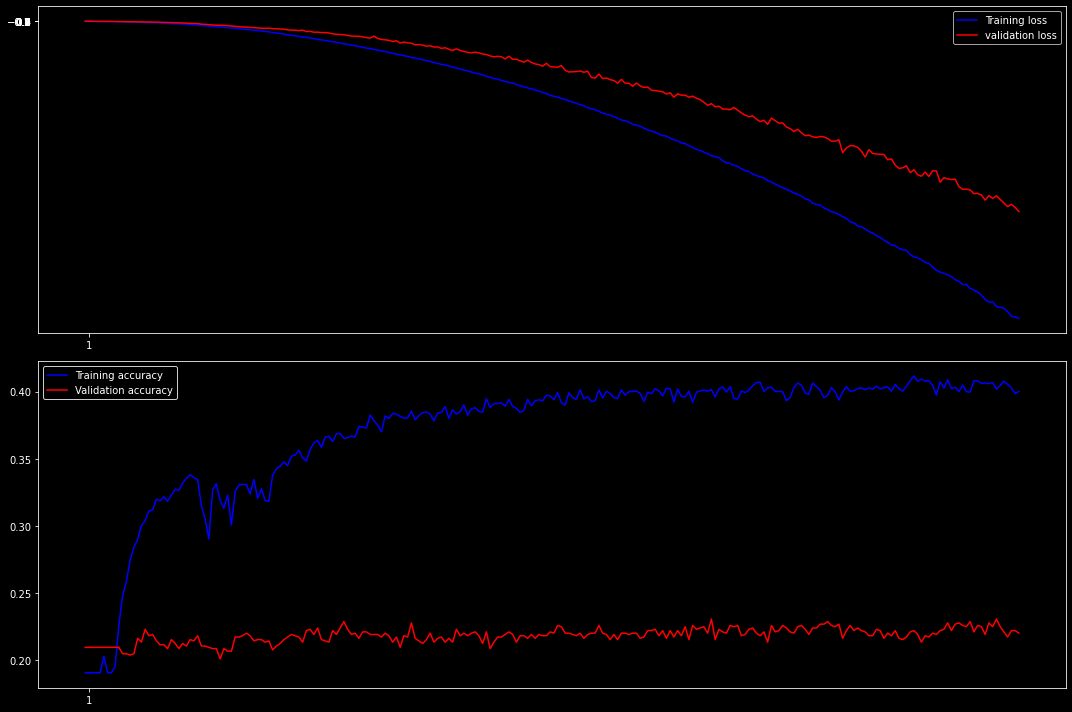

In [101]:
epochs=8

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 10))
ax1.set_yticks(np.arange(-0.2, 1, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 10))
ax2.legend()

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [92]:
lstm_model.save('/content/drive/MyDrive/Ass 7/sentiment_final.hdf5')

In [93]:
"""
from keras import models    
model = models.load_model('/content/drive/MyDrive/Ass 7/sentiment_final.hdf5', compile = False)
"""

"\nfrom keras import models    \nmodel = models.load_model('/content/drive/MyDrive/Ass 7/sentiment_final.hdf5', compile = False)\n"

In [103]:
df_test = pd.read_csv("/content/drive/MyDrive/Ass 7/SST_2/test.csv", encoding='latin-1')
print(df_test)

                                          sentence_test sentiment_test
0     ordinary melodrama that is heavy on religious ...  very_negative
1                 -LRB- A -RRB- rare , beautiful film .  very_positive
2     -LRB- Drumline -RRB- is entertaining for what ...       positive
3     -LRB- Schweiger is -RRB- talented and terribly...       positive
4     -LRB- Wendigo is -RRB- why we go to the cinema...       positive
...                                                 ...            ...
2120  despite the long running time , the pace never...       positive
2121  focuses on Joan 's raging hormones and sledgeh...  very_negative
2122                                  just pound away .        neutral
2123  s personal revelations regarding what the shop...  very_positive
2124                              well worth the time .  very_positive

[2125 rows x 2 columns]


In [95]:
lem = WordNetLemmatizer()
def preprocessing(data):
      sms = contractions.fix(data) 
      sms = sms.lower()
      sms = re.sub(r'https?://S+|www.S+', "", sms).strip() #removing url
      sms = re.sub("[^a-z ]", "", sms) # removing symbols and numbes
      sms = sms.split() 
      sms = [lem.lemmatize(word) for word in sms if not word in set(stopwords.words("english"))]
      sms = " ".join(sms)
      return sms
X_test = df_test["sentence_test"].apply(preprocessing)
print(X_test)

0       ordinary melodrama heavy religious symbol wafe...
1                             lrb rrb rare beautiful film
2              lrb drumline rrb entertaining admirable nt
3       lrb schweiger rrb talented terribly charismati...
4            lrb wendigo rrb go cinema fed eye heart mind
                              ...                        
2120    despite long running time pace never feel slac...
2121    focus joan raging hormone sledgehammer audienc...
2122                                           pound away
2123    personal revelation regarding shop mean big pi...
2124                                      well worth time
Name: sentence_test, Length: 2125, dtype: object


In [102]:
from sklearn.preprocessing import LabelEncoder
Level_test = df_test['sentiment_test'].values
lb_enc = LabelEncoder()
y_test = lb_enc.fit_transform(df_test["sentiment_test"])
print(y_test)

[3 4 2 2 2 4 4 2 4 2 1 2 4 4 1 2 1 4 4 2 2 2 4 2 2 2 4 2 2 4 4 4 4 4 4 0 2
 2 2 2 2 2 2 4 2 4 2 2 2 4 2 4 4 2 2 1 4 2 1 4 4 2 4 2 4 2 2 4 2 4 4 2 2 1
 4 4 1 4 2 1 4 2 2 1 2 4 0 2 2 2 2 4 4 1 4 2 2 4 2 4 1 1 2 1 0 2 2 1 1 2 2
 1 2 2 2 2 2 4 2 2 4 4 2 4 2 2 4 4 0 1 4 2 2 2 2 2 0 0 2 2 4 2 4 2 1 4 2 4
 1 2 1 2 4 1 4 2 4 2 2 4 2 4 2 4 2 4 2 2 0 2 4 4 1 1 2 3 4 2 2 0 2 2 4 4 2
 2 1 2 4 4 4 1 4 2 2 4 4 4 4 2 4 2 2 4 4 2 2 4 2 4 2 2 2 2 4 4 4 2 4 2 2 2
 4 4 2 2 1 2 0 1 2 1 4 2 2 0 1 2 2 4 1 2 2 4 2 2 4 1 1 2 4 4 2 2 4 2 2 1 4
 0 4 2 2 4 4 4 4 4 2 2 1 2 4 4 4 4 2 4 4 4 2 4 1 4 1 2 1 2 2 1 2 4 4 2 1 2
 4 2 4 4 4 0 0 2 2 4 0 4 1 4 2 4 4 4 2 4 4 1 2 0 2 1 2 2 1 4 2 4 4 4 4 4 4
 4 4 4 1 4 2 2 4 2 4 2 4 4 4 2 2 4 2 2 4 2 4 1 2 1 1 4 2 2 4 2 4 2 1 0 4 4
 4 3 1 0 1 2 1 4 4 2 1 4 4 4 4 4 2 4 2 4 2 2 4 4 2 2 4 4 4 2 4 2 4 4 2 4 2
 4 4 4 2 4 4 4 4 4 2 2 2 2 4 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 4 2 4 2 4 4 1 4
 2 2 4 2 2 2 4 2 2 4 4 2 2 4 4 2 2 2 2 2 4 2 2 4 4 4 2 4 4 4 4 1 2 2 2 2 2
 4 2 1 4 4 2 2 2 1 4 4 0 

In [97]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_test)
text_to_sequence_test = tokenizer.texts_to_sequences(X_test)
print(text_to_sequence_test)

[[2718, 317, 515, 790, 2719, 2720, 424, 622], [425, 426, 217, 427, 1], [425, 2721, 426, 116, 1105, 3], [425, 2722, 426, 791, 1106, 2723, 318, 1107, 2, 125, 792, 2724], [425, 2725, 426, 64, 178, 2726, 277, 100, 151], [2727, 278, 2], [20, 152, 1582, 516, 108, 5, 2728, 84], [319, 623, 1108, 2729, 793, 2730, 2731, 2732, 1109, 1583, 2733], [2734, 2735, 1110, 34, 65, 428, 794, 25, 2736, 429, 139, 279], [1584, 6, 1111, 795, 1585, 26], [280, 2737, 1586, 2738, 796, 2739, 126, 1112, 797, 798], [1113, 799, 1587, 9, 800, 2740, 166], [218, 57, 1], [624, 40, 22, 85, 625], [1588, 1589, 801, 1590, 1591, 2, 16, 117], [626, 2741, 75, 627, 2742], [515, 2743, 802, 1592, 803, 2744, 179], [1593, 1, 804, 91, 805, 2745, 2746, 167, 2747, 2748], [1594, 367, 38, 219], [320, 220, 517, 1595, 806, 2749], [518, 20, 2, 807, 197, 2750, 1114, 52], [67, 2, 67, 41, 76, 28, 217, 1115, 368, 28, 3, 86], [519, 808, 1, 809, 628, 127, 430, 319, 221, 2751, 1116, 222, 30, 431, 1117, 369], [68, 9, 1596, 629, 2752, 2753], [520, 11

In [99]:
max_length_sequence_test = max([len(i) for i in text_to_sequence_test])
 
padded_sequence_test= pad_sequences(text_to_sequence_test, maxlen=28, 
                                    padding = "pre") 
padded_sequence_test

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0, 2718,  317,
         515,  790, 2719, 2720,  424,  622],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  425,  426,  217,  427,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         425, 2721,  426,  116, 1105,    3],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  425, 2722,  426,  791, 1106, 2723,
         318, 1107,    2,  125,  792, 2724],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  425, 2725,  426,
          64,  178, 2726,  277,  100,  151],
       [   0,    0,    0,    0,    

In [100]:
from sklearn.metrics import accuracy_score
prediction = lstm_model.predict(padded_sequence_test)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(y_test,pred_labels))

Accuracy of prediction on test set :  0.19811764705882354


In [111]:
sentence = ["Yet the act is still charming here", 
            "A droll , bitchy frolic which pokes fun at the price of popularity and small-town pretension in the Lone Star State", 
            "A party-hearty teen flick that scalds like acid"]

sequences = tokenizer.texts_to_sequences(sentence)

padded = pad_sequences(sequences, padding='post', maxlen=28)
prediction = lstm_model.predict(padded)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 0:
        s = 'negative '
    elif pred_labels[i] == 1:
        s = 'neutral'
    elif pred_labels[i] == 2:
        s = 'positive'
    elif pred_labels[i] == 3:
        s = 'very_negative'
    elif pred_labels[i] == 4:
        s = 'very_positive'
    print("Predicted sentiment : ",s)

Yet the act is still charming here
Predicted sentiment :  neutral
A droll , bitchy frolic which pokes fun at the price of popularity and small-town pretension in the Lone Star State
Predicted sentiment :  neutral
A party-hearty teen flick that scalds like acid
Predicted sentiment :  neutral
